In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import medfilt
import japanize_matplotlib
import math


In [18]:
# CSVファイルを読み込む
file_path = "./logs/terminal_coordinate/"

df_gyro = pd.read_csv(
    f"{file_path}Gyroscope.csv",
    header=0,
    names=("time", "x", "y", "z")
)

df_acc = pd.read_csv(
    f"{file_path}Accelerometer.csv",
    header=0,
    names=("time", "x", "y", "z")
)


In [19]:
# 加速度のノルムを計算する
df_acc['norm'] = np.linalg.norm(df_acc[['x', 'y', 'z']], axis=1)

# フィルターをかける
window = 40
## 移動平均
df_acc['xlow'] = df_acc['x'].rolling(window=window).mean()
df_acc['ylow'] = df_acc['y'].rolling(window=window).mean()
df_acc['zlow'] = df_acc['z'].rolling(window=window).mean()

## メディアンフィルター
df_acc['xmf'] = medfilt(df_acc['x'], window + 1)
df_acc['ymf'] = medfilt(df_acc['y'], window + 1)
df_acc['zmf'] = medfilt(df_acc['z'], window + 1)

## 移動平均
df_gyro['xlow'] = df_gyro['x'].rolling(window=window).mean()
df_gyro['ylow'] = df_gyro['y'].rolling(window=window).mean()
df_gyro['zlow'] = df_gyro['z'].rolling(window=window).mean()

## メディアンフィルター
df_gyro['xmf'] = medfilt(df_gyro['x'], window + 1)
df_gyro['ymf'] = medfilt(df_gyro['y'], window + 1)
df_gyro['zmf'] = medfilt(df_gyro['z'], window + 1)


In [20]:
# 角速度から角度を計算する
t = df_gyro['time'].max() - df_gyro['time'].min()
n = len(df_gyro)
a = t / n * 180 / np.pi

df_gyro['i_x'] = np.cumsum(df_gyro['x']) * a
df_gyro['i_y'] = np.cumsum(df_gyro['y']) * a
df_gyro['i_z'] = np.cumsum(df_gyro['z']) * a

df_gyro['i_xlow'] = np.cumsum(df_gyro['xlow']) * a
df_gyro['i_ylow'] = np.cumsum(df_gyro['ylow']) * a
df_gyro['i_zlow'] = np.cumsum(df_gyro['zlow']) * a

df_gyro['i_xmf'] = np.cumsum(df_gyro['xmf']) * a
df_gyro['i_ymf'] = np.cumsum(df_gyro['ymf']) * a
df_gyro['i_zmf'] = np.cumsum(df_gyro['zmf']) * a


In [21]:
# グラフを描画する
def plot(
    df,
    heads=[],
    title=None,
    xlabel=None,
    ylabel=None,
    figsize=(10, 3),
    xlim=(0, 0),
    ylim=(0, 0),
    grid=True,
):
    fig = plt.figure(figsize=figsize)

    if title:
        plt.title(title)
    if xlabel:
        plt.xlabel(xlabel)
    if ylabel:
        plt.ylabel(ylabel)
    if grid:
        plt.grid(color='k', linestyle='dotted', linewidth=1, alpha=0.5)

    if xlim[0] < xlim[1]:
        plt.xlim(xlim[0], xlim[1])
    if ylim[0] < ylim[1]:
        plt.ylim(ylim[0], ylim[1])

    for head in heads:
        plt.plot(df[head[0]], df[head[1]], label=head[1])

    plt.legend()

    plt.show()


In [22]:
# 3次元グラフを描画する
def plot_arrow(
    point,
    xlim=(0, 0),
    ylim=(0, 0),
    zlim=(0, 0),
    figsize=(10, 10),
):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection='3d')
    if xlim[0] < xlim[1]:
        ax.set_xlim(xlim[0], xlim[1])
    if ylim[0] < ylim[1]:
        ax.set_ylim(ylim[0], ylim[1])
    if zlim[0] < zlim[1]:
        ax.set_zlim(zlim[0], zlim[1])

    ax.quiver(
        0, 0, 0,
        point[0], point[1], point[2],
        arrow_length_ratio=0.1
    )

    plt.show()


In [23]:
def calculate_tilt(df):
    tilt_angles = []  # 傾きを格納するリスト

    # df を for で回す
    for d in df.itertuples(index=False):
        time = d.time
        x = d.x
        y = d.y
        z = d.z
        
        gravity = math.sqrt(x ** 2 + y ** 2 + z ** 2)

        # 重力方向となす角度を計算
        tilt_angle_x = math.acos(x / gravity)
        tilt_angle_y = math.acos(y / gravity)
        tilt_angle_z = math.acos(z / gravity)

        tilt_angles.append((time, tilt_angle_x, tilt_angle_y, tilt_angle_z))

    df_tilt = pd.DataFrame(tilt_angles, columns=["time", "roll", "pitch", "yaw"])
    return df_tilt


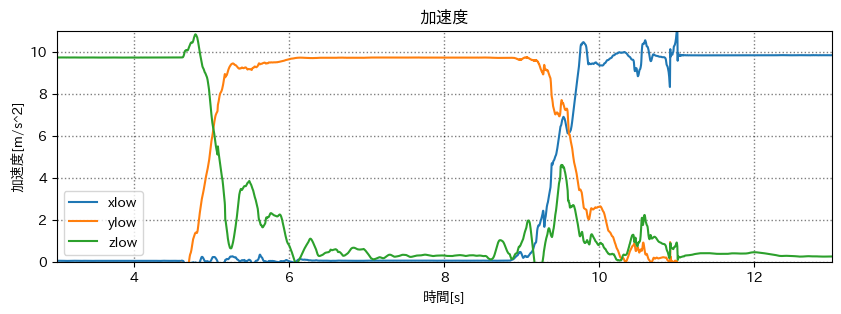

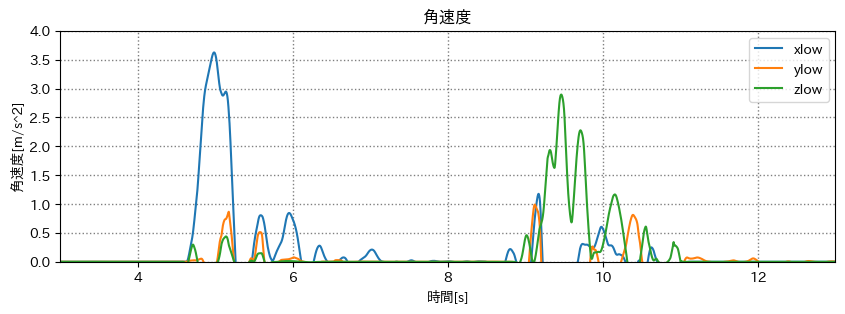

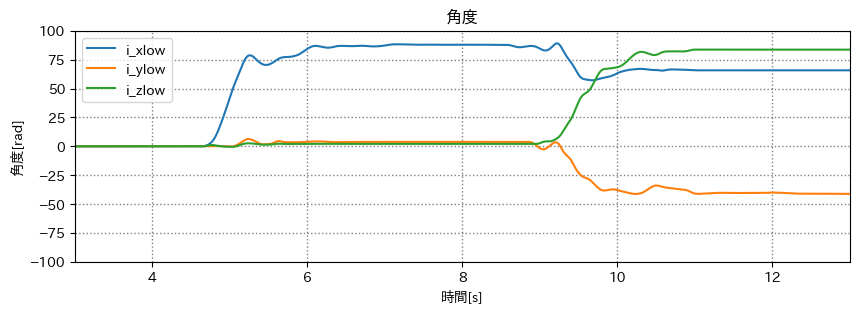

In [24]:
plot(
    df_acc,
    [("time", "xlow"), ("time", "ylow"), ("time", "zlow")],
    title="加速度",
    xlabel="時間[s]",
    ylabel="加速度[m/s^2]",
    figsize=(10, 3),
    xlim=(3, 13),
    ylim=(0, 11),
    grid=True
)

plot(
    df_gyro,
    [("time", "xlow"), ("time", "ylow"), ("time", "zlow")],
    title="角速度",
    xlabel="時間[s]",
    ylabel="角速度[m/s^2]",
    figsize=(10, 3),
    xlim=(3, 13),
    ylim=(0, 4),
    grid=True
)

plot(
    df_gyro,
    [("time", "i_xlow"), ("time", "i_ylow"), ("time", "i_zlow")],
    title="角度",
    xlabel="時間[s]",
    ylabel="角度[rad]",
    figsize=(10, 3),
    xlim=(3, 13),
    ylim=(-100, 100),
    grid=True
)


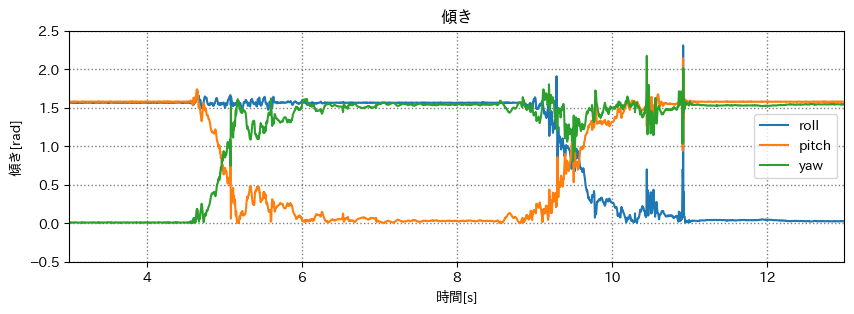

In [25]:
df_tilt = calculate_tilt(df_acc)

plot(
    df_tilt,
    [("time", "roll"), ("time", "pitch"), ("time", "yaw")],
    title="傾き",
    xlabel="時間[s]",
    ylabel="傾き[rad]",
    figsize=(10, 3),
    xlim=(3, 13),
    ylim=(-0.5, 2.5),
    grid=True
)

roll = np.radians(df_tilt['roll'])
pitch = np.radians(df_tilt['pitch'])
yaw = np.radians(df_tilt['yaw'])

rotation_matrix = np.array([[
    np.cos(yaw) * np.cos(pitch),
    np.cos(yaw) * np.sin(pitch) * np.sin(roll) - np.sin(yaw) * np.cos(roll),
    np.cos(yaw) * np.sin(pitch) * np.cos(roll) + np.sin(yaw) * np.sin(roll)
], [
    np.sin(yaw) * np.cos(pitch),
    np.sin(yaw) * np.sin(pitch) * np.sin(roll) + np.cos(yaw) * np.cos(roll),
    np.sin(yaw) * np.sin(pitch) * np.cos(roll) - np.cos(yaw) * np.sin(roll)
], [
    -np.sin(pitch),
    np.cos(pitch) * np.sin(roll),
    np.cos(pitch) * np.cos(roll)
]])

acceleration = df_acc[['x', 'y', 'z']]  # 加速度データをnumpy配列に変換
world_acceleration = np.dot(acceleration, rotation_matrix.T)  # 加速度データを回転行列で修正


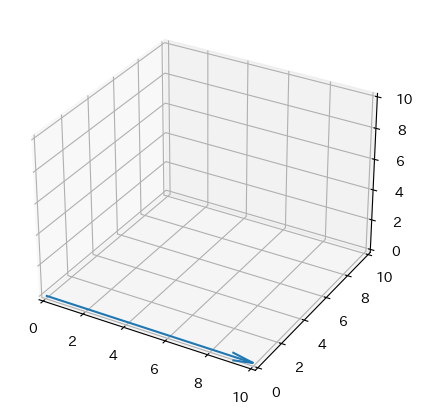

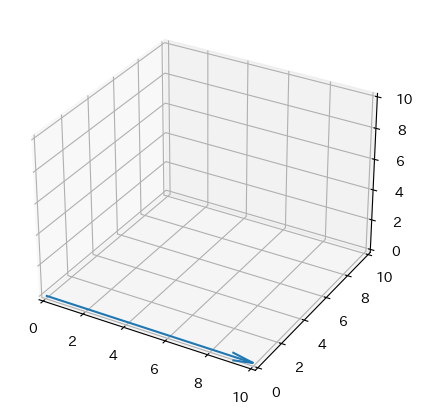

In [32]:
vec = np.array([10, 0, 0])

roll = np.pi / 4
pitch = 0
yaw = 0

rotation_matrix_x = np.array([[1, 0, 0],
                              [0, np.cos(roll), -np.sin(roll)],
                              [0, np.sin(roll), np.cos(roll)]])

rotation_matrix_y = np.array([[np.cos(pitch), 0, np.sin(pitch)],
                              [0, 1, 0],
                              [-np.sin(pitch), 0, np.cos(pitch)]])

rotation_matrix_z = np.array([[np.cos(yaw), -np.sin(yaw), 0],
                              [np.sin(yaw), np.cos(yaw), 0],
                              [0, 0, 1]])

vec_rotated = np.dot(
    np.dot(rotation_matrix_z, rotation_matrix_y),
    np.dot(rotation_matrix_x, vec)
)


# 表示
plot_arrow(vec, xlim=(0, 10), ylim=(0, 10), zlim=(0, 10), figsize=(5, 5))
plot_arrow(vec_rotated, xlim=(0, 10), ylim=(0, 10), zlim=(0, 10), figsize=(5, 5))
